## HRNET - Pose Estimation

This notebook shows how to compile HRNET/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK. We'll use pre-trained models provided the author. 

**Reference:** https://github.com/leoxiaobin/deep-high-resolution-net.pytorch.git

Predicted keypoints for pose estimation:  
```
{0,  "Nose"},
{1,  "LEye"},
{2,  "REye"},
{3,  "LEar"},
{4,  "REar"},
{5,  "LShoulder"},
{6,  "RShoulder"},
{7,  "LElbow"},
{8,  "RElbow"},
{9,  "LWrist"},
{10, "RWrist"},
{11, "LHip"},
{12, "RHip"},
{13, "LKnee"},
{14, "Rknee"},
{15, "LAnkle"},
{16, "RAnkle"},
```

## 1) Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron==1.10.2.2.3.0.0 neuron-cc[tensorflow] torchvision
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

In [ ]:
# some dependencies required 
%pip install yacs json_tricks pycocotools
# now restart the kernel again

### 1.1) Download the model implementation + weights 

In [ ]:
import os
import urllib.request

if not os.path.isfile('pose_hrnet_w48_384x288.pth'):
    urllib.request.urlretrieve('https://eurmqg.ch.files.1drv.com/y4mNy2IRQtZ8_2fiDe8-Usmo4MGjRnWRgb2y3jGIx8wq5PQ4ABVUqSZqaumGtuUfhjQpNN8OlpOQZB3Q5gZ11lif97gLj8zaKgPgyYzFdgd8yIiq8rFWsh5oTIxCh9UTyah8gxiqS9ldmIp24C_zKrNOXrMwttYDiMZdA8XaY-g5t3bt2G37fjfWk6qnkyb7lHUFaW-zUhddzpClyRgYCNZYA/pose_hrnet_w48_384x288.pth', 'pose_hrnet_w48_384x288.pth')

if not os.path.isdir('deep-high-resolution-net.pytorch'):
    !git clone https://github.com/leoxiaobin/deep-high-resolution-net.pytorch.git
    !cd deep-high-resolution-net.pytorch/lib/nms/ && python setup_linux.py build && python setup_linux.py install

## 2) Initialize libraries and prepare input samples

In [ ]:
import sys
sys.path.insert(0, 'deep-high-resolution-net.pytorch/lib')
sys.path.insert(1, 'deep-high-resolution-net.pytorch/lib/nms/')
sys.path.insert(2, 'deep-high-resolution-net.pytorch/lib/models/')
import pose_hrnet
import torch
from config import cfg
from config import update_config
from core.inference import get_max_preds

class ARGS(object):
    pass
args = ARGS()
args.cfg = 'deep-high-resolution-net.pytorch/experiments/coco/hrnet/w48_384x288_adam_lr1e-3.yaml'
args.opts = ''
args.modelDir = '.'
args.logDir = '.'
args.dataDir = '.'
args.TEST = ARGS()
args.TEST.BATCH_SIZE_PER_GPU = 1
args.WORKERS = 1
args.GPUS = (0)
args.TEST.MODEL_FILE = 'pose_hrnet_w48_384x288.pth'
args.TEST.USE_GT_BBOX = True
update_config(cfg, args)

x = torch.rand(1,3,288,384).float().cpu()

## 3) Load a pre-trained model and check if it is .jit traceable


In [ ]:
model = pose_hrnet.get_pose_net(cfg, is_train=False)
model.load_state_dict(torch.load('pose_hrnet_w48_384x288.pth', map_location='cpu'))
model.eval()

y = model(x) # warmup the model
try:
    traced_model = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")
## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch.neuron
torch.neuron.analyze_model(model, x)

In [ ]:
## this can take ~25mins
import torch.neuron
model_neuron = torch.neuron.trace(model,x)
model_neuron.save('pose_hrnet_w48_384x288_neuron.pt')

In [ ]:
model_neuron(x) # warmup
%timeit model_neuron(x)

## 5) A simple test to check the predictions

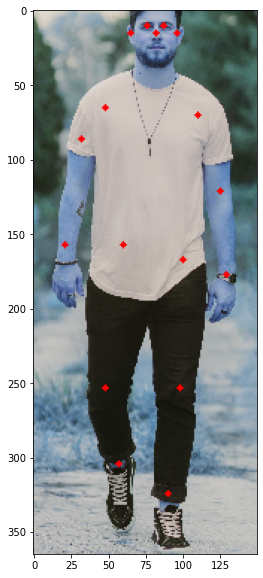

In [43]:
%matplotlib inline
import sys
for path in [
    'deep-high-resolution-net.pytorch/lib',
    'deep-high-resolution-net.pytorch/lib/models',
    'deep-high-resolution-net.pytorch/lib/nms',
    '..'
]: 
    if path not in sys.path: 
        sys.path.insert(0,path)
import cv2
import torch
import torch.neuron
import numpy as np
import matplotlib.pyplot as plt

from core.inference import get_max_preds
from common import processing
from torchvision.transforms import transforms

# load model
model_neuron = torch.load('pose_hrnet_w48_384x288_neuron.pt')

img = processing.load_sample_imgC()
img = cv2.resize(img, (0,0), fx=0.1, fy=0.1)
img = img[160:525, 160:310]

def get_keypoints(preds, img_shape=(384,288)):
    # Ok. Now we need to extract the keypoints from each heatmap
    coords, maxvals = get_max_preds(preds.clone().detach().numpy())    
    img_h, img_w = img_shape
    mask_h, mask_w = preds.shape[2:4]
    return np.append((coords[0] / (mask_w, mask_h) * (img_w, img_h)), maxvals[0], axis=1)    

x = transformer(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (384,288))).unsqueeze(0)
y = model_neuron(x)
keypoints = get_keypoints(y, img.shape[0:2])

for k in keypoints:
    cv2.circle(img, (int(k[0]), int(k[1])), 2, (255,0,0), -1)
plt.figure(figsize=(10,10))
plt.imshow(img)

Done :)